# ARIMA 모델을 사용한 시계열 데이터 예측 예제
## : 한국전력공사, KT, 현대의 주가 데이터셋을 중심으로

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; ARIMA 모델을 사용하여 시계열 데이터를 예측한다. 시계열 데이터로 '한국전력공사', 'KT', '현대'의 2012년부터 2017년까지의 약 5년 간의 주가(종가)를 사용한다. 각 데이터의 특징으로, '한국전력공사'의 경우 초반 4년간 상승세지만 하향세 형태이며, 'KT'의 경우 소폭 하향이지만 대체로 횡보하는 형태이고 '현대'의 경우 전체적으로 하향 추세에 해당한다. 각 데이터에 대한 통계적 안정성을 확인하였으며, 세 데이터 모두 유의수준 값 0.588, 0.092, 0.437로 유의수준 0.05에서 안정적이지 않은 것을 확인하여, '데이터 로그 처리'와 '시계열 분해'를 수행함으로써
모든 데이터에 대해 유의수준 값 0.000으로 안정한 형태로 변환 하였다. 이후, 데이터에 대한 ARIMA 모델의 적절한 모수를 탐색하였으며, 모든 데이터는 state1(p=1, q=0, d=1), state2(p=1, q=1, d=1)의 경우로 나누어 모델을 학습, 평가 하였다. 평가 지표로 MAPE를 사용하였다. 그 결과 한국전력공사의 경우 p=1, q=0, d=1일 때, MAPE가 7.78%이었으며, KT의 경우 p=1, q=0, d=1일 때, MAPE가 4.47%이고 현대의 경우 q가 0 또는 1인 모든 경우에서 MAPE가 10.34%임을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 ARIMA 모델을 이용한 시계열 데이터의 예측을 목표로 합니다. 다양한 상황에서의 모델의 예측을 확인하기 위해 형태가 다른 '한국전력공사', 'KT', '현대'의 주가 데이터를 사용합니다. ARIMA 모델을 생성하고 학습하기에 앞서 데이터를 분석하고 나아가 모델 예측 가능성을 확인하기 위해 adfuller 메소드를 사용하여 데이터의 안정성(stationary)을 통계적 안정성을 확인 하는 과정을 진행합니다. 이후, ARIMA 모수의 탐색, 설정 과정을 거쳐 모델 학습 및 평가를 시행 합니다. 다음은 예제의 진행 순서를 제시한 것입니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. ARIMA 모수 탐색_
>
> _4. ARIMA 모델 생성 및 학습_
>
> _5. ARIMA 모델 평가_


***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 예제에서 사용하는 데이터를 분석 합니다. 데이터는 한국전력공사, KT, 현대의 2012년 1월 2일부터 2017년 12월 28일까지 약 5년 간의 주가 데이터를 이용합니다. 데이터는 크게 일자별 주가(close)와 거래량(volume)으로 구성되어 있습니다. 모든 데이터는 각 1,477개의 레코드를 가지고 있으며 결측치는 존재하지 않습니다. 각 데이터의 주가 형태는 다음과 같습니다. 한국전력공사의 경우 우상향의 형태를 보이다 마지막 1년 쯤으로부터 하향세를 보이는 형태 입니다. KT의 경우 약한 하향세이지만 대체로 횡보하는 형태 입니다. 현대의 경우 전체적으로 우하향의 형태 입니다. 또한 각 데이터는 통계적으로 안정성이 확보되지 않으며, 이는 전처리가 필요함을 의미합니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 필요 라이브러리를 호출 합니다.
***

In [1]:
import os   #디렉토리 관리
import math   #연산
import numpy as np   #행렬 연산
import pandas as pd   #데이터프레임
import matplotlib.pyplot as plt   #데이터 시각화


from statsmodels.tsa.arima_model import ARIMA   #ARIMA 모델
from statsmodels.tsa.stattools import adfuller   #안정성 통계적 여부
from statsmodels.tsa.seasonal import seasonal_decompose   #시계열 분해
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   #ARIMA graph
from sklearn.metrics import mean_squared_error, mean_absolute_error   #손실 값


import warnings   #경고
warnings.filterwarnings('ignore')   #경고 무시

<br>

#### 데이터 불러오기
***
+ 예제에서 사용할 '한국전력공사', 'KT', '현대'의 2012년 1월 2일부터 2017년 12월 28일까지 5년간의 주가 데이터를 불러옵니다.


+ 데이터는 일자별 주가(`close`)와 거래량(`volume`)으로 구성되어 있습니다.
***

In [2]:
def get_open_dataset(file_path):
    column = ["open", "high", "low", "close", "volume"]
    df = pd.read_csv(file_path, header=None, thousands=",", index_col=0)
    df.columns = column
    df.drop(columns=["open", "high", "low"], inplace=True)
    df = df.loc["2012-01-02":"2017-12-28"]
    return df


kepco_dataset = get_open_dataset("/aiffel/aiffel/ex/ex14/dataset/KEPCO.csv")
kt_dataset = get_open_dataset("/aiffel/aiffel/ex/ex14/dataset/kt.csv")
hyundai_dataset = get_open_dataset("/aiffel/aiffel/ex/ex14/dataset/hyundai.csv")

kepco_ts = kepco_dataset['close']
kt_ts = kt_dataset['close']
hyundai_ts = hyundai_dataset['close']

kepco_dataset

,close,volume
0,,
2012-01-02,25100,763150
2012-01-03,25650,994385
2012-01-04,26050,1409633
2012-01-05,27050,2161506
2012-01-06,27050,1208888
...,...,...
2017-12-21,38700,1276728
2017-12-22,38750,898070
2017-12-26,39100,1477510


<br>

#### 필요 함수 생성
***
+ 주가 및 거래량을 시각화 하는 함수와 `adfuller` 메소드를 활용한 통계적 안정성을 확인하는 함수를 생성 합니다.
***

In [3]:
#주가, 거래량 시각화 함수=======================
def show_stock(df, title):
    fig, axe = plt.subplots(figsize=(15, 4))
    plt.title(title, size= 13)
    
    rolmean = df["close"].rolling(window=120).mean()  # 이동평균 시계열
    rolstd = df["close"].rolling(window=120).std()    # 이동표준편차 시계열

    axe.get_xaxis().get_major_formatter().set_scientific(False)
    axe.get_yaxis().get_major_formatter().set_scientific(False)

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    axe.set_ylabel("Volume")

    x = np.arange(len(df))
    volume = df["volume"].tolist()

    axe.bar(x, volume, color="b", alpha=0.3)

    ax = axe.twinx()
    ax.set_ylabel("close")
    ax.plot(df["close"], color="green", label="close")
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black', alpha=0.5, label = 'Rolling Std')
    ax.legend()
    plt.show()
    return None
#End============================================


#통계적 안성정 확인 함수========================
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  

    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput)
    return None
#End============================================

<br>

### 2.1 한국전력공사(015760)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 한국전력공사는 2012년부터 2016년 상승 추세, 2017년 하락 추세 종목입니다. 전체적으로 상승세 이지만 최근 하향세를 겪는 경우 ARIMA 모델의 예측을 확인하기 위해 채택하였습니다. 총 1,477개의 레코드가 있으며, 평균 주가는 약 40,168원이며 표준편차는 약 10,659원 입니다. 최저가는 21,450원이고 최고가는 63,000원 입니다. ADF 테스트를 이용하여 주가의 안정성을 확인한 결과 유의수준 0.05에서 유의수준 값(p-value) 0.588로 주가는 안정적이지 않은 것으로 판단 할 수 있습니다. &lt;Fig. 1>은 한국전력공사의 주가를 시각화 한 것입니다.
</span>

***

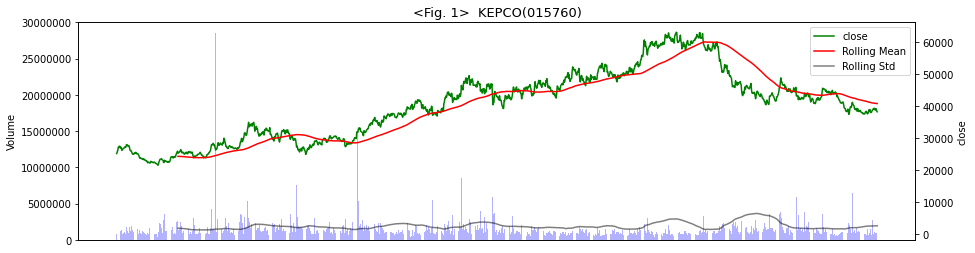

In [4]:
show_stock(kepco_dataset, "<Fig. 1>  KEPCO(015760)")

<br>

#### 데이터 기본 정보
***
+ 총 1,477개의 레코드가 있으며, 평균 주가는 약 40,168원 이고 표준편차는 약 10,659원 입니다.


+ 최저가는 21,450원, 최고가는 63,000원 입니다.
***

In [5]:
kepco_dataset.describe()

,close,volume
count,1477.000000,1.477000e+03
mean,40168.314150,1.427559e+06
std,10659.933155,1.259385e+06
min,21450.000000,3.503720e+05
25%,30050.000000,8.879110e+05
50%,41750.000000,1.178426e+06
75%,47000.000000,1.649874e+06
max,63000.000000,2.857442e+07


<br>

#### 데이터 결측치 확인
***
+ 총 1,477개의 레코드이며 결측치는 존재하지 않습니다.
***

In [6]:
print("*" * 50)
kepco_dataset.info()
print("*" * 50)

**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 2012-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1477 non-null   int64
 1   volume  1477 non-null   int64
dtypes: int64(2)
memory usage: 34.6+ KB
**************************************************


<br>

#### 통계적 안정성 여부 판단
***
+ ADF(Augmented Dickey-Fuller) 테스트를 통해 '한국전력공사'의 주가에 대한 안정성(stationary)을 확인한 결과 유의수준 0.05에서 유의수준 값 0.588이므로 대립가설을 기각하고 귀무가설을 채택하여, '한국전력공사의 주가는 안정적이지 않다'고 할 수 있습니다.
***

In [7]:
print("*" * 50)
augmented_dickey_fuller_test(kepco_ts)
print("*" * 50)

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -1.386493
p-value           0.588734
dtype: float64
**************************************************


<br>

### 2.2 KT(030200)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; KT는 2012년부터 2017년까지 박스권 종목으로 2012년부터 약 1년 6개월 간 어느정도의 상승과 하락의 변동성을 보이다 이후 횡보하는 모양세 입니다. 변동이 크지 않고 횡보하는 형태에서의 ARIMA 모델의 에측을 확인하기 위해 채택하였습니다. 총 1,477개의 레코드가 있으며, 평균 주가는 약 32,011원이며 표준편차는 약 2,813원 입니다. 최저가는 26,350원이고 최고가는 408,500원 입니다. ADF 테스트를 이용하여 주가의 안정성을 확인한 결과 유의수준 0.05에서 유의수준 값(p-value) 0.092로 주가는 안정적이지 않은 것으로 판단 할 수 있습니다. &lt;Fig. 2>은 KT의 주가를 시각화 한 것입니다.
</span>

***

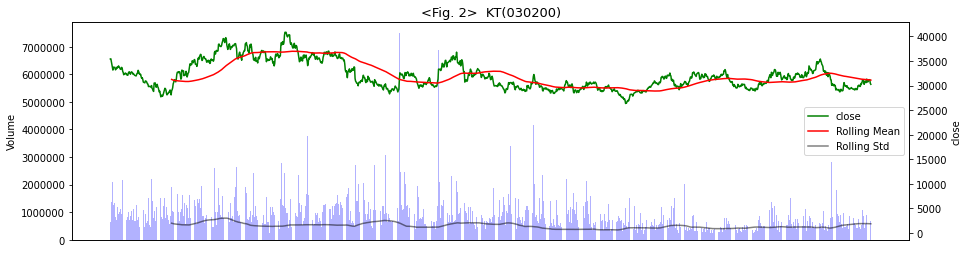

In [8]:
show_stock(kt_dataset, "<Fig. 2>  KT(030200)")

<br>

#### 데이터 기본 정보
***
+ 총 1,477개의 레코드가 있으며, 평균 주가는 약 32,011원 이고 표준편차는 약 2,813원 입니다.


+ 최저가는 26,350원, 최고가는 40,850원 입니다.
***

In [9]:
kt_dataset.describe()

,close,volume
count,1477.000000,1.477000e+03
mean,32011.069736,9.038831e+05
std,2813.080595,6.074715e+05
min,26350.000000,1.711240e+05
25%,29800.000000,5.371470e+05
50%,31450.000000,7.563650e+05
75%,33750.000000,1.103414e+06
max,40850.000000,7.509245e+06


<br>

#### 데이터 결측치 확인
***
+ 총 1,477개의 레코드이며 결측치는 존재하지 않습니다.
***

In [10]:
print("*" * 50)
kt_dataset.info()
print("*" * 50)

**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 2012-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1477 non-null   int64
 1   volume  1477 non-null   int64
dtypes: int64(2)
memory usage: 34.6+ KB
**************************************************


<br>

#### 통계적 안정성 여부 판단
***
+ ADF(Augmented Dickey-Fuller) 테스트를 통해 'KT'의 주가에 대한 안정성(stationary)을 확인한 결과 유의수준 0.05에서 유의수준 값 0.092이므로 대립가설을 기각하고 귀무가설을 채택하여, 'KT의 주가는 안정적이지 않다'고 할 수 있습니다.


+ '통계적으로는 안정적이지 않다'고 할 수 있으나 앞선 '한국전력공사'에 비해 안정적이라 할 수 있으며, 이는 KT의 주가가 한국전력공사에 비해 변동 폭이 적고 횡보하는 형태를 보이기 때문이라 할 수 있습니다.
***

In [11]:
print("*" * 50)
augmented_dickey_fuller_test(kt_ts)
print("*" * 50)

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -2.603856
p-value           0.092203
dtype: float64
**************************************************


<br>

### 2.2 현대(005380)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 현대는 전체적으로 하락 추세 입니다. 하락세 형태에서의 ARIMA 모델의 예측을 확인하기 위해 채택하였습니다. 총 1,477개의 레코드가 있으며, 평균 주가는 약 186,531원이며 표준편차는 약 41,514원 입니다. 최저가는 123,500원이고 최고가는 268,500원 입니다. ADF 테스트를 이용하여 주가의 안정성을 확인한 결과 유의수준 0.05에서 유의수준 값(p-value) 0.437로 주가는 안정적이지 않은 것으로 판단 할 수 있습니다. &lt;Fig. 3>은 현대의 주가를 시각화 한 것입니다.
</span>

***

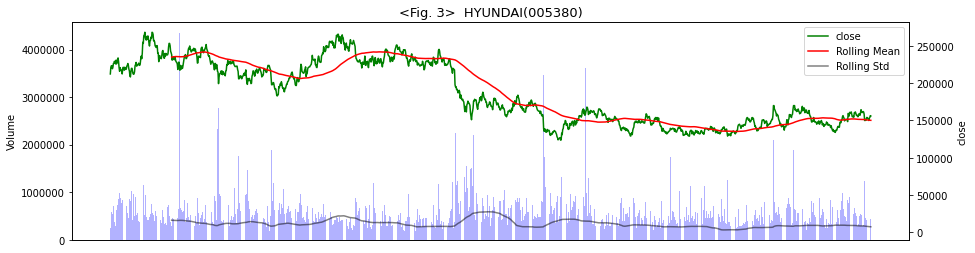

In [12]:
show_stock(hyundai_dataset, "<Fig. 3>  HYUNDAI(005380)")

<br>

#### 데이터 기본 정보
***
+ 총 1,477개의 레코드가 있으며, 평균 주가는 약 186,531원 이고 표준편차는 약 41,514원 입니다.


+ 최저가는 123,500원, 최고가는 268,500원 입니다.
***

In [13]:
hyundai_dataset.describe()

,close,volume
count,1477.000000,1.477000e+03
mean,186531.821259,5.913497e+05
std,41514.735233,3.399425e+05
min,123500.000000,1.641340e+05
25%,148500.000000,3.890550e+05
50%,172500.000000,5.177520e+05
75%,227000.000000,6.922180e+05
max,268500.000000,4.353189e+06


<br>

#### 데이터 결측치 확인
***
+ 총 1,477개의 레코드이며 결측치는 존재하지 않습니다.
***

In [14]:
print("*" * 50)
hyundai_dataset.info()
print("*" * 50)

**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 2012-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1477 non-null   int64
 1   volume  1477 non-null   int64
dtypes: int64(2)
memory usage: 34.6+ KB
**************************************************


<br>

#### 통계적 안정성 여부 판단
***
+ ADF(Augmented Dickey-Fuller) 테스트를 통해 '현대'의 주가에 대한 안정성(stationary)을 확인한 결과 유의수준 0.05에서 유의수준 값 0.437이므로 대립가설을 기각하고 귀무가설을 채택하여, '현대의 주가는 안정적이지 않다'고 할 수 있습니다.
***

In [15]:
print("*" * 50)
augmented_dickey_fuller_test(hyundai_ts)
print("*" * 50)

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -1.688289
p-value           0.437156
dtype: float64
**************************************************


<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 각 데이터가 통계적으로 안정적이지 않음을 확인하였습니다. 따라서 데이터 전처리 과정을 통해 데이터를 안정적인 형태로 만들고자 합니다. 데이터를 안정적인 형태로 만들기 위해서 '데이터 로그 처리', '시계열 분해' 과정을 거칩니다. 특히, 시계열 분해는 '추세(Trend) 상쇄'와 '계절성(Seasonality) 상쇄'를 중심으로 이루어집니다. 이후, ARIMA 모델을 학습 및 평가하기 위해 데이터를 학습 데이터와 테스트 데이터로 분할하는 작업을 시행합니다.
</span>

***

### 3.1. 로그 처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 각 데이터에 로그를 씌워 데이터의 안정성을 소폭 향상 시킵니다. 한국전력공사의 경우 유의수준 값 0.589에서 0.438로 안정성이 소폭 상승 되었습니다. KT의 경우 유의수준 값 0.092에서 0.089로 안정성이 소폭 상승 되었습니다. 하지만, 현대의 경우 유의수준 값 0.437에서 0.500로 안정성이 소폭 저하 되었습니다. [표 1]은 로그처리에 따른 데이터의 통계적 안정성 변화를 제시한 것입니다.
</span><br><br>

|stock|oroginal data p-value|log data p-value|
|:--------:|:--------:|:--------:|
|**KEPCO(015760)**|0.589|0.438|
|**KT(030200)**|0.092|0.086|
|**HYUNDAI(005380)**|0.437|0.500|
[표 1] 로그처리에 따른 데이터의 통계적 안정성 변화

***

#### 데이터 로그 처리
***
+ 각 데이터에 로그를 씌워 '안정성'을 소폭 상승 시킵니다.


+ '한국전력공사'와 'KT'의 주가에 로그를 씌운 경우 '안정성'이 소폭 상승 하였지만, '현대'의 경우 안정성이 오히려 떨어졌습니다.
***

In [16]:
kepco_ts_log = np.log(kepco_ts)
kt_ts_log = np.log(kt_ts)
hyundai_ts_log = np.log(hyundai_ts)

print("\n<KEPCO LOG stationary>" + "*" * 38)
augmented_dickey_fuller_test(kepco_ts_log)
print("*" * 60)

print("\n<KT LOG stationary>" + "*" * 41)
augmented_dickey_fuller_test(kt_ts_log)
print("*" * 60)

print("\n<HYUNDAI LOG stationary>" + "*" * 36)
augmented_dickey_fuller_test(hyundai_ts_log)
print("*" * 60)


<KEPCO LOG stationary>**************************************
Results of Dickey-Fuller Test:
Test Statistic   -1.687162
p-value           0.437739
dtype: float64
************************************************************

<KT LOG stationary>*****************************************
Results of Dickey-Fuller Test:
Test Statistic   -2.633751
p-value           0.086220
dtype: float64
************************************************************

<HYUNDAI LOG stationary>************************************
Results of Dickey-Fuller Test:
Test Statistic   -1.566590
p-value           0.500351
dtype: float64
************************************************************


<br>

### 3.2. 시계열 분해
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 시계열 분해는 '추세(Trend) 상쇄'와 '계절성(Seasonality) 상쇄'를 중심으로 이루어집니다. 추세란 시간에 따른 평균값의 변화로 '추세 상쇄'는 이러한 변화량을 제거하여 수행 할 수 있습니다. 또한, 계절성 상쇄는 패턴이 파악되지 않은 주기적 변화를 의미하며, 이를 제거하기 위해 차분을 이용하여 수행 합니다. 각 데이터에 시계열 분해를 수행한 결과, 각 데이터에 대해 유의수준 값 0.000으로 데이터가 안정적임을 확인 하였습니다.
</span><br><br>

|stock|oroginal data p-value|log data p-value|Time series decomposition p-value|
|:--------:|:--------:|:--------:|:--------:|
|**KEPCO(015760)**|0.589|0.438|0.000|
|**KT(030200)**|0.092|0.086|0.000|
|**HYUNDAI(005380)**|0.437|0.500|0.000|
[표 2] 시계열 분해에 따른 데이터의 통계적 안정성 변화

***

#### 시계열 분해 시각화 함수 생성
***
+ 데이터에 대한 시계열 분해 과정의 '추세 상쇄'와 '계절성 상쇄'를 시각화 하는 함수를 생성 합니다.
***

In [17]:
def show_residual(ts_log):
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
    residual = decomposition.resid
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    visual_dic = {
        "Oroginal": ts_log, "Treind": trend, "Seasonality": seasonal, "Residuals": residual
    }
    
    plt.figure(figsize=(15, 7))
    for idx, (title, data) in enumerate(visual_dic.items()):
        plt.subplot(4, 1, idx + 1)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.plot(data, label=title, color="blue", alpha=0.5)
        plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return None

<br>

### 3.2.1. 한국전력공사(015760)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 한국전력공사 데이터에 대한 시계열 분해를 시행 합니다. 시계열 분해의 결과인 'residuals'에 대한 통계적 안정성 여부를 판단한 결과 유의수준 0.05에서 유의수준 값 0.000으로 안정적인 것을 확인 하였습니다. 아래는 시계열 분해를 시각화 한 것으로 'Trend'는 추세를, 'Seasonaliry'는 계절성, 'Residuals'는 시계열 분해의 결과를 시각화 한 것입니다.
</span>

***

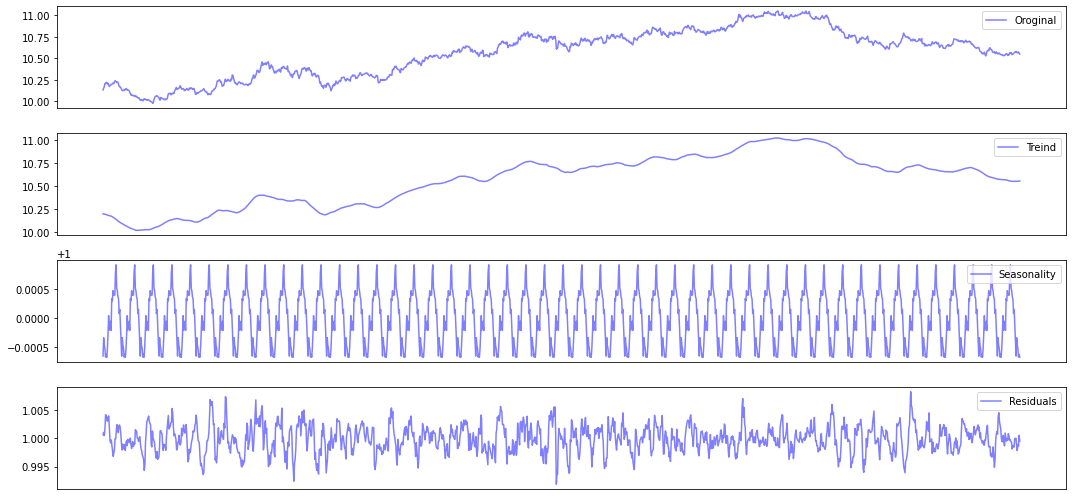

In [18]:
decomposition = seasonal_decompose(kepco_ts_log, model='multiplicative', period = 30)
kepco_residual = decomposition.resid
kepco_residual.dropna(inplace=True)

show_residual(kepco_ts_log)

<br>

#### 통계적 안정성 여부 판단
***
+ '한국전력공사' 데이터에 대한 시계열 분해 결과, 유의수준 0.05에서 유의수준 값 0.000으로 대립가설을 채택하여 시계열 분해한 한국전력공사의 주가는 안정적이라 할 수 있습니다.
***

In [19]:
print("*" * 50)
augmented_dickey_fuller_test(kepco_residual)
print("*" * 50)

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -1.333381e+01
p-value           6.108441e-25
dtype: float64
**************************************************


<br>

### 3.2.2. KT(030200)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; KT 데이터에 대한 시계열 분해를 시행 합니다. 시계열 분해의 결과인 'residuals'에 대한 통계적 안정성 여부를 판단한 결과 유의수준 0.05에서 유의수준 값 0.000으로 안정적인 것을 확인 하였습니다. 아래는 시계열 분해를 시각화 한 것으로 'Trend'는 추세를, 'Seasonaliry'는 계절성, 'Residuals'는 시계열 분해의 결과를 시각화 한 것입니다.
</span>

***

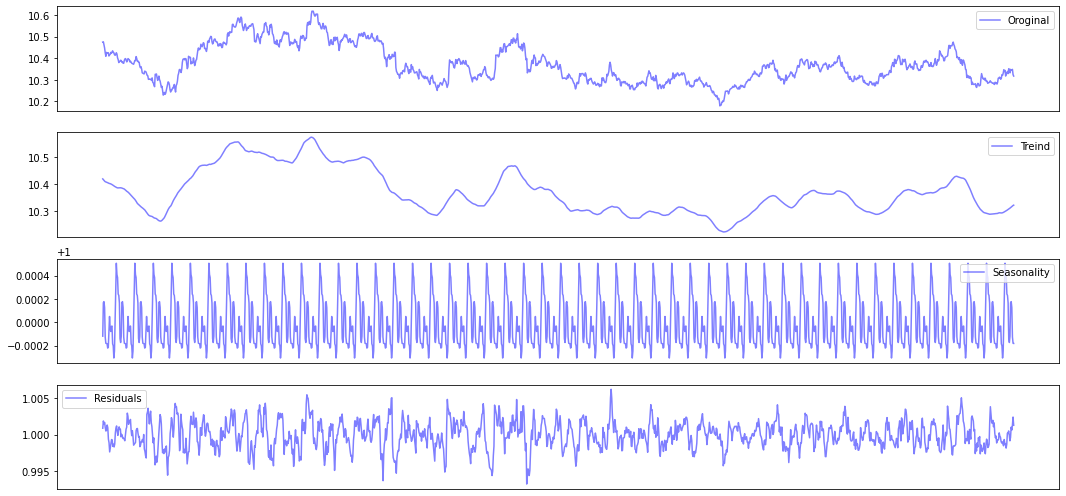

In [20]:
decomposition = seasonal_decompose(kt_ts_log, model='multiplicative', period = 30)
kt_residual = decomposition.resid
kt_residual.dropna(inplace=True)

show_residual(kt_ts_log)

<br>

#### 통계적 안정성 여부 판단
***
+ 'KT' 데이터에 대한 시계열 분해 결과, 유의수준 0.05에서 유의수준 값 0.000으로 대립가설을 채택하여 시계열 분해한 KT의 주가는 안정적이라 할 수 있습니다.
***

In [21]:
print("*" * 50)
augmented_dickey_fuller_test(kt_residual)
print("*" * 50)

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -1.089525e+01
p-value           1.196759e-19
dtype: float64
**************************************************


<br>

### 3.2.3. 현대(005380)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 현대 데이터에 대한 시계열 분해를 시행 합니다. 시계열 분해의 결과인 'residuals'에 대한 통계적 안정성 여부를 판단한 결과 
유의수준 0.05에서 유의수준 값 0.000으로 안정적인 것을 확인 하였습니다. 아래는 시계열 분해를 시각화 한 것으로 'Trend'는 추세를, 'Seasonaliry'는 계절성, 'Residuals'는 시계열 분해의 결과를 시각화 한 것입니다.
</span>

***

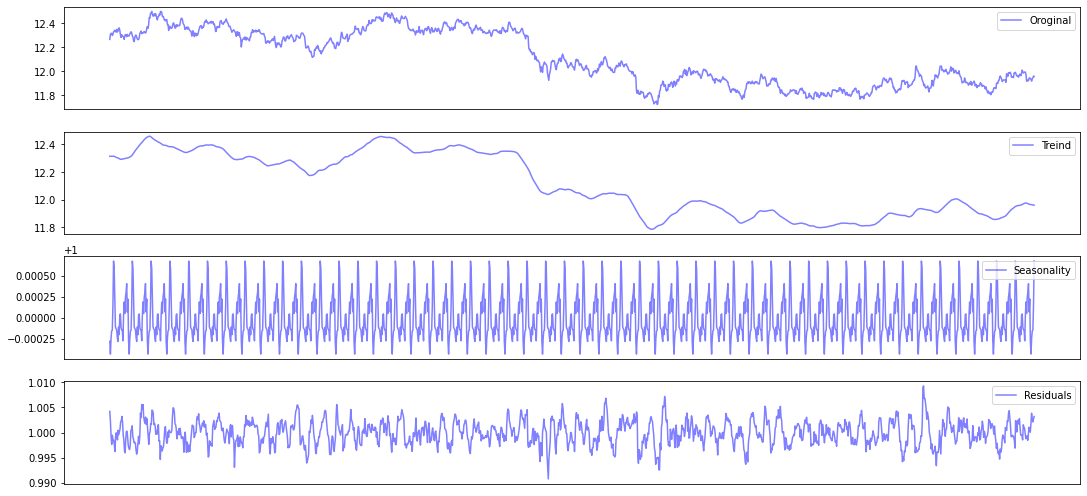

In [22]:
decomposition = seasonal_decompose(hyundai_ts_log, model='multiplicative', period = 30)
hyundai_residual = decomposition.resid
hyundai_residual.dropna(inplace=True)

show_residual(hyundai_ts_log)

<br>

#### 통계적 안정성 여부 판단
***
+ '현대' 데이터에 대한 시계열 분해 결과, 유의수준 0.05에서 유의수준 값 0.000으로 대립가설을 채택하여 시계열 분해한 현대의 주가는 안정적이라 할 수 있습니다.
***

In [23]:
print("*" * 50)
augmented_dickey_fuller_test(hyundai_residual)
print("*" * 50)

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -1.323925e+01
p-value           9.242750e-25
dtype: float64
**************************************************


<br>

### 3.3. 데이터 분할
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모델을 학습 및 평가하기 위해 각 데이터를 학습 데이터와 테스트 데이터로 분할 합니다. 데이터는 학습 데이터 90%, 테스트 데이터 10%의 비율로 분할 합니다. 그 결과, 학습 데이터 1,329개, 테스트 데이터 148개를 얻을 수 있습니다. &lt;Fig. 4>는 분할한 데이터를 시각화 한 것입니다.
</span>

***

#### 데이터 분할 실시
***
+ 각 데이터에 대해 9:1의 비율로 학습데이터와 테스트 데이터를 분할 합니다.


+ 그 결과 1,329개의 학습 데이터와 148개의 테스트 데이터를 확보 하였습니다.
***

In [24]:
def split_data(data, rate):
    split_idx = int(len(data) * rate)
    train_data, test_data = data[:split_idx], data[split_idx:]
    return (train_data, test_data)


kepco_train_data, kepco_test_data = split_data(kepco_ts_log, 0.9)
kt_train_data, kt_test_data = split_data(kt_ts_log, 0.9)
hyundai_train_data, hyundai_test_data = split_data(hyundai_ts_log, 0.9)


print("*" * 50)
print(f"Train data's length: {len(kepco_train_data)}")
print(f"Test data's length: {len(kepco_test_data)}")
print("*" * 50)

**************************************************
Train data's length: 1329
Test data's length: 148
**************************************************


<br>

#### 분할 데이터 시각화
***
+ 분할한 학습 데이터와 테스트 데이터를 시각화 합니다.
***

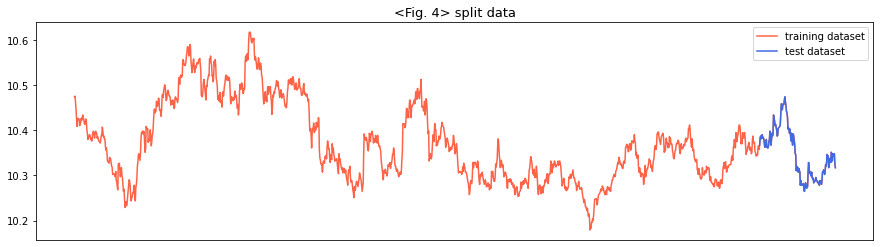

In [25]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.title("<Fig. 4> split data", size= 13)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.plot(kt_ts_log, c='tomato', label='training dataset')
ax.plot(kt_test_data, c='royalblue', label='test dataset')
ax.grid(False)
ax.legend()
plt.show()

<br>

## 4. ARIMA 모수 탐색
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모델을 학습하기 이전에 모수를 설정할 필요가 있습니다. ARIMA의 모수는 p, q, d로 p는 자기회귀 모형(AR)의 시차,
q는 이동평균 모형(MA)의 시차, d는 차분누적(I) 횟수 입니다. PACF(Partial Autocorrelation Function)를 바탕으로 현재 데이터와의 상관도를 파악하며, 이를 토대로 p를 설정할 수 있습니다. q의 경우에는 ACF를 기준으로 설정합니다. 일반적으로 p와 q는 둘 중 하나의 값을 0으로 설정 합니다. d의 경우에는 데이터를 n 만큼 차분하여 데이터가 안정 될 때, d = n으로 설정 합니다. 이러한 내용을 바탕으로 '한국전력공사', 'KT', '현대'의 주가를 분석하여 ARIMA의 모수인 p, q, d를 설정 합니다.
</span>

***

#### ACF & PACF 및 차분 시각화 함수 생성
***
+ `ARIMA` 모수 `p`, `q`를 탐색 하기위해 `ACF`와 `PACF`를 시각화 하는 함수를 생성 합니다.


+ `d`를 탐색하기 위한 차분을 시각화 하는 함수를 생성 합니다.
***

In [26]:
def show_acf_pacf(data):
    fig = plt.figure(figsize=(15, 8))
    plt.subplots_adjust(top=0.9, hspace=0.3)
    ax1 = fig.add_subplot(2, 1, 1)
    plot_acf(data, ax=ax1)   # ACF : Autocorrelation 그래프 그리기

    ax2 = fig.add_subplot(2, 1, 2)
    plot_pacf(data, ax=ax2)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()
    return None


def show_diff(data):
    diff_1 = data.diff(periods=1).iloc[1:]
    
    print("*" * 50)
    augmented_dickey_fuller_test(diff_1)
    print("*" * 50)
    
    fig = plt.figure(figsize=(15, 4))
    diff_1.plot(title='Difference 1st')
    plt.xlabel(None)
    plt.show()
    return None

<br>

### 4.1. 한국전력공사(015760)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 한국전력공사 데이터의 ARIMA 모수를 탐색합니다. PACF를 확인한 결과 2이상부터 0에 수렴하는 것을 확인하였습니다. 이는 2부터 현재 데이터와 상관이 없는 데이터라 볼 수 있으므로 p를 1로 설정 합니다. ACF를 확인한 결과 서서히 값이 감소하기 때문에 q를 단정적으로 설정할 수 없습니다. 하지만, 일반적으로 p와 q 중 하나의 값이 설정될 경우 나머지 한 값은 0으로 설정하기 때문에 q를 0과 1의 두 경우로 구분하여 설정합니다. 데이터를 1차분 한 결과 데이터가 통계적으로 안정되어 있음을 확인하여 d를 1로 설정 합니다.
</span><br><br>

|State|p|q|d|
|:--------:|:--------:|:--------:|:--------:|
|**state1**|1|0|1|
|**state2**|1|1|1|

[표 3] 한국전력공사(015760) ARIMA 채택 모수

***

#### ACF 및 PACF 확인을 통한 p, q 결정
***
+ `PACF(Partial Autocorrelation)`의 경우 2이상부터 0에 수렴하므로 2부터 현재 데이터와 상관이 없는 데이터로 볼 수 있으므로 `p`를 1로 설정 합니다.



+ `ACF(Autocorrelation)`의 경우 값이 서서히 감소하며 절단 가능 부분을 구분하는 것이 어려우며, 기본적으로 `p`와 `q` 중 하나의 값은 0으로 설정하기 때문에 `q`를 0인 경우와 1인 경우, 두 경우로 구분하여 학습 및 평가를 진행합니다.
***

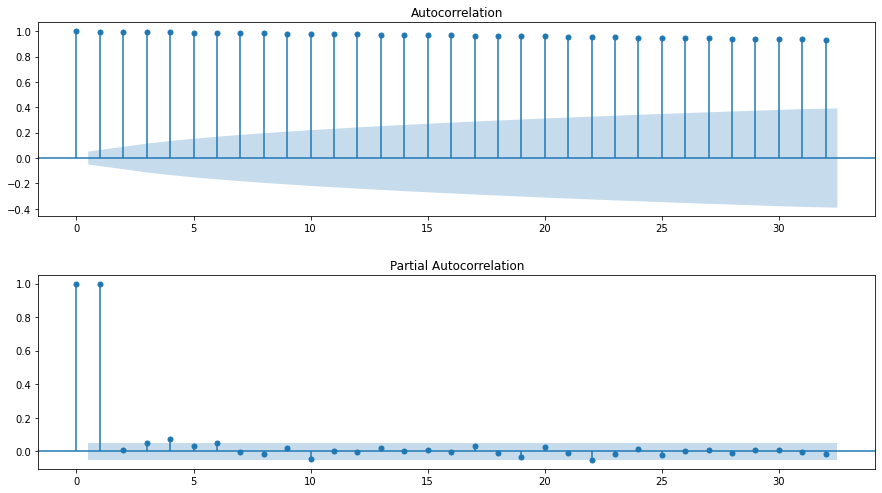

In [27]:
show_acf_pacf(kepco_ts_log)

<br>

#### 차분 확인을 통한 d 결정
***
+ `d`를 설정하기 위해 데이터의 차분을 구한 결과, 1차분으로 데이터가 안정된 것을 확인하여 `d`를 1로 설정 합니다.
***

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -23.68662
p-value            0.00000
dtype: float64
**************************************************


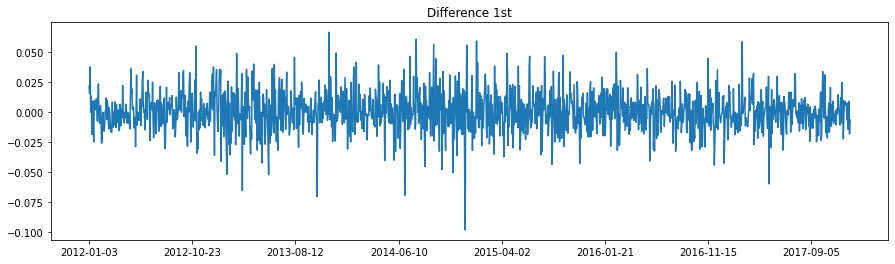

In [28]:
show_diff(kepco_ts_log)

<br>

### 4.2. KT(030200)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; KT 데이터의 ARIMA 모수를 탐색합니다. PACF를 확인한 결과 2이상부터 0에 수렴하는 것을 확인하였습니다. 이는 2부터 현재 데이터와 상관이 없는 데이터라 볼 수 있으므로 p를 1로 설정 합니다. ACF를 확인한 결과 서서히 값이 감소하기 때문에 q를 단정적으로 설정할 수 없습니다. 하지만, 일반적으로 p와 q 중 하나의 값이 설정될 경우 나머지 한 값은 0으로 설정하기 때문에 q를 0과 1의 두 경우로 구분하여 설정합니다. 데이터를 1차분 한 결과 데이터가 통계적으로 안정되어 있음을 확인하여 d를 1로 설정 합니다.
</span><br><br>

|State|p|q|d|
|:--------:|:--------:|:--------:|:--------:|
|**state1**|1|0|1|
|**state2**|1|1|1|

[표 4] KT(030200) ARIMA 채택 모수

***

#### ACF 및 PACF 확인을 통한 p, q 결정
***
+ `PACF(Partial Autocorrelation)`의 경우 2이상부터 0에 수렴하므로 2부터 현재 데이터와 상관이 없는 데이터로 볼 수 있으므로 `p`를 1로 설정 합니다.



+ `ACF(Autocorrelation)`의 경우 값이 서서히 감소하며 절단 가능 부분을 구분하는 것이 어려우며, 기본적으로 `p`와 `q` 중 하나의 값은 0으로 설정하기 때문에 `q`를 0인 경우와 1인 경우, 두 경우로 구분하여 학습 및 평가를 진행합니다.
***

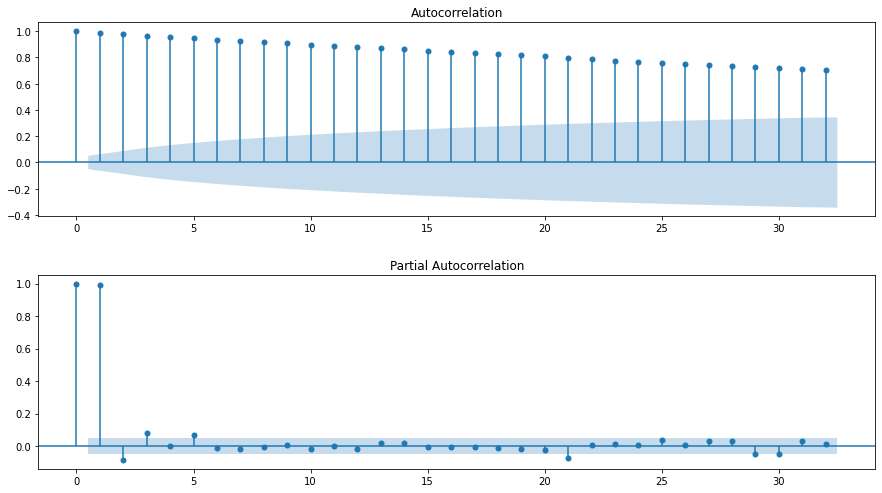

In [29]:
show_acf_pacf(kt_ts_log)

<br>

#### 차분 확인을 통한 d 결정
***
+ `d`를 설정하기 위해 데이터의 차분을 구한 결과, 1차분으로 데이터가 안정된 것을 확인하여 `d`를 1로 설정 합니다.
***

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -20.837244
p-value            0.000000
dtype: float64
**************************************************


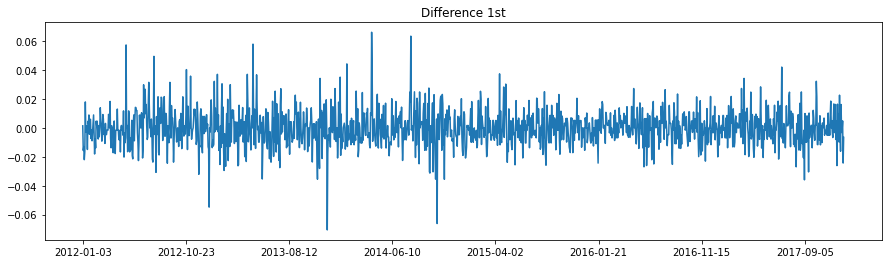

In [30]:
show_diff(kt_ts_log)

<br>

### 4.3. 현대(005380)¶
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 현대 데이터의 ARIMA 모수를 탐색합니다. PACF를 확인한 결과 2이상부터 0에 수렴하는 것을 확인하였습니다. 이는 2부터 현재 데이터와 상관이 없는 데이터라 볼 수 있으므로 p를 1로 설정 합니다. ACF를 확인한 결과 서서히 값이 감소하기 때문에 q를 단정적으로 설정할 수 없습니다. 하지만, 일반적으로 p와 q 중 하나의 값이 설정될 경우 나머지 한 값은 0으로 설정하기 때문에 q를 0과 1의 두 경우로 구분하여 설정합니다. 데이터를 1차분 한 결과 데이터가 통계적으로 안정되어 있음을 확인하여 d를 1로 설정 합니다.
</span><br><br>

|State|p|q|d|
|:--------:|:--------:|:--------:|:--------:|
|**state1**|1|0|1|
|**state2**|1|1|1|

[표 5] 현대(005380) ARIMA 채택 모수

***

#### ACF 및 PACF 확인을 통한 p, q 결정
***
+ `PACF(Partial Autocorrelation)`의 경우 2이상부터 0에 수렴하므로 2부터 현재 데이터와 상관이 없는 데이터로 볼 수 있으므로 `p`를 1로 설정 합니다.



+ `ACF(Autocorrelation)`의 경우 값이 서서히 감소하며 절단 가능 부분을 구분하는 것이 어려우며, 기본적으로 `p`와 `q` 중 하나의 값은 0으로 설정하기 때문에 `q`를 0인 경우와 1인 경우, 두 경우로 구분하여 학습 및 평가를 진행합니다.
***

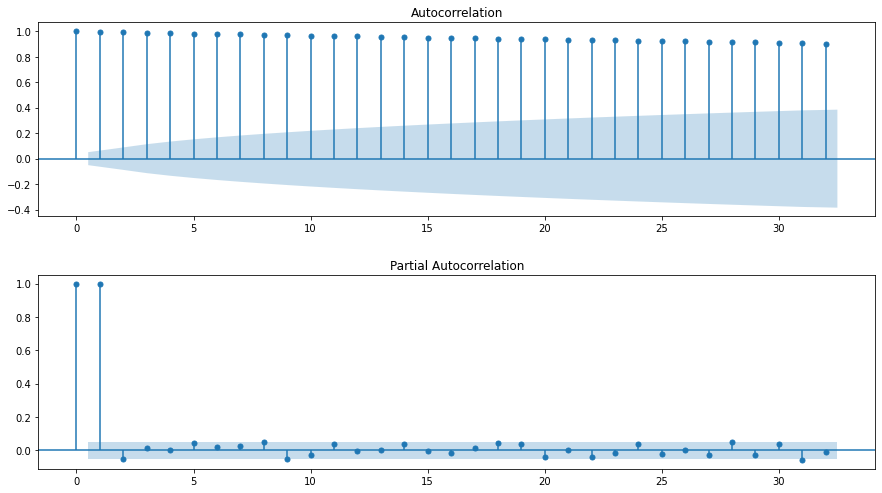

In [31]:
show_acf_pacf(hyundai_ts_log)

<br>

#### 차분 확인을 통한 d 결정
***
+ `d`를 설정하기 위해 데이터의 차분을 구한 결과, 1차분으로 데이터가 안정된 것을 확인하여 `d`를 1로 설정 합니다.
***

**************************************************
Results of Dickey-Fuller Test:
Test Statistic   -37.171327
p-value            0.000000
dtype: float64
**************************************************


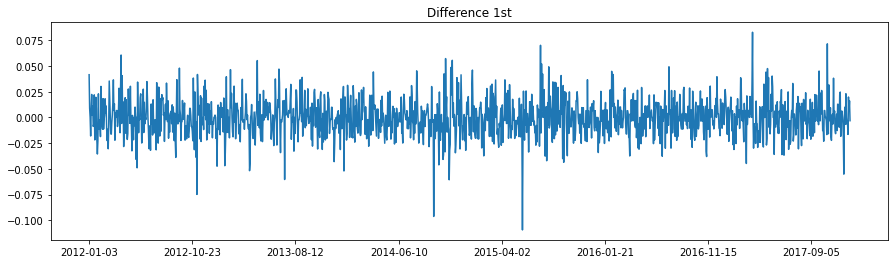

In [32]:
show_diff(hyundai_ts_log)

<br>

## 5. ARIMA 모델 훈련 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 설정한 ARIMA 모델의 모수를 바탕으로 모델을 학습 및 평가 합니다. 모델 평가 시에는  MAPE를 사용 합니다. MAPE는 MAE의 결과가 정규화 되지 않는 것을 해결하기 위해 제안 된 것으로 수식은 다음과 같습니다.
</span>

$$MAPE = \frac{100}{n}\sum_{i=1}^{n}\left\lvert \frac{y_i-\hat{f}(x_i)}{y_i} \right\rvert$$

***

#### ARIMA 모델 예측 및 손실값 시각화 함수 생성
***
+ `ARIMA` 모델 예측 함수 및 손실값 시각화 함수를 생성 합니다.
***

In [33]:
def show_predict(train_data, test_data, title):
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(15, 4), dpi=100)
    plt.title(title, size= 13)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    return None


def show_loss(test_data):
    fc, _, _ = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    
    print("*" * 50)
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))
    print("*" * 50)
    return None

<br>

### 5.1. 한국전력공사(015760)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 한국전력공사 데이터에 대한 ARIMA 모델 학습 및 평가를 시행 합니다. q가 0일 때와 1일 때로 구분하여 평가를 진행하였습니다.
그 결과, state1(p=1, q=0, d=1)일 때, MAPE 7.77% 이었으며 state2(p=1, q=1, d=1)일 때, MAPE 7.90% 임을 확인하였습니다. 따라서, q를 0으로 설정하였을 때, 보다 예측을 잘 한 것으로 이해할 수 있습니다. [표 6]은 한국전력공사 데이터에 대한 ARIMA 모델의 state에 따른 MAPE 손실값을 제시한 것입니다.
</span><br><br>

|State|p|q|d|MAPE|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|**state1**|1|0|1|**7.78**|
|**state2**|1|1|1|**7.90**|

[표 6] 한국전력공사(015760) ARIMA 모델 MAPE 손실값

***

### 5.1.1. state1에 대한 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모수 p=1, q=0, d=1일 때, 한국전력공사 데이터에 대한 모델의 학습 및 평가 입니다. MAE는 3061.626이며, MAPE는 7.78% 임을 확인하였습니다. &lt;Fig. 5>는 이를 시각화 한 것입니다. 실제론 하락하였지만 모델은 상승할 것으로 예측하였습니다. 이는 현재의 하락세보다 과거의 상승세에 더 중점을 둔 것이라 해석할 수 있습니다.
</span>

***

#### 모델 학습
***
+ `한국전력공사(015760)`에 대한 모수로 `p`=1, `q`=0, `d`=1을 설정한 `ARIMA` 모델을 학습 합니다.
***

In [34]:
model = ARIMA(kepco_train_data, order=(1, 1, 0))   #p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1328
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3512.936
Method:                       css-mle   S.D. of innovations              0.017
Date:                Sun, 14 Nov 2021   AIC                          -7019.872
Time:                        15:05:07   BIC                          -7004.298
Sample:                             1   HQIC                         -7014.035
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      0.819      0.413      -0.001       0.001
ar.L1.D.close     0.0116      0.027      0.422      0.673      -0.042       0.065
                                    Root

<br>

#### 모델 예측 시각화
***
+ `한국전력공사(015760)`에 대한 모수로 `p`=1, `q`=0, `d`=1을 설정한 `ARIMA` 모델을 예측을 시각화 합니다.
***

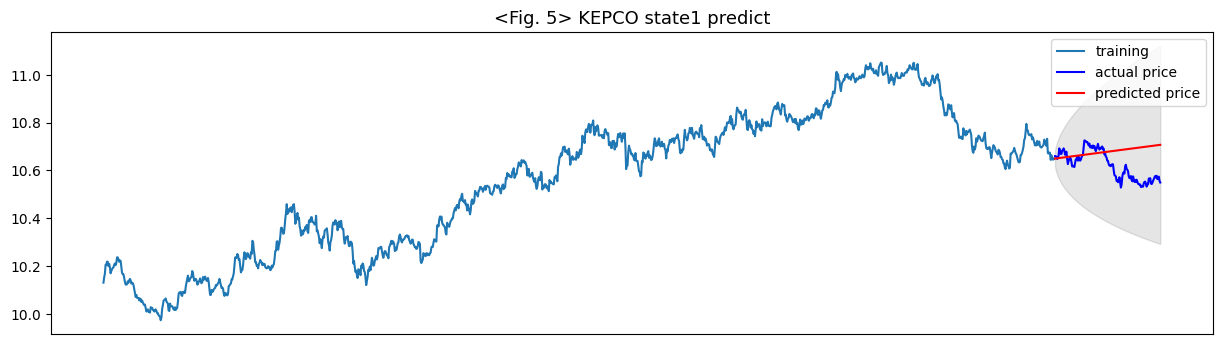

In [35]:
show_predict(kepco_train_data, kepco_test_data, "<Fig. 5> KEPCO state1 predict")

<br>

#### 모델 손실값
***
+ ARIMA 모델의 예측에 대한 손실값을 출력한 결과 `MAPE`가 7.78%임을 확인 할 수 있습니다.
***

In [36]:
show_loss(kepco_test_data)

**************************************************
MSE:  14655869.620190814
MAE:  3061.62648779105
RMSE:  3828.298528091927
MAPE: 7.78%
**************************************************


<br>

### 5.1.2. state2에 대한 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모수 p=1, q=1, d=1일 때, 한국전력공사 데이터에 대한 모델의 학습 및 평가 입니다. MAE는 3106.948이며, MAPE는 7.90% 임을 확인하였습니다. &lt;Fig. 6>는 이를 시각화 한 것입니다. 앞의 state1과 비슷한 예측을 하였으며, state1보다 MAPE값이 0.12 상승하였습니다.
</span>

***

#### 모델 학습
***
+ `한국전력공사(015760)`에 대한 모수로 `p`=1, `q`=1, `d`=1을 설정한 `ARIMA` 모델을 학습 합니다.
***

In [37]:
model = ARIMA(kepco_train_data, order=(1, 1, 1))   #p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1328
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3514.257
Method:                       css-mle   S.D. of innovations              0.017
Date:                Sun, 14 Nov 2021   AIC                          -7020.513
Time:                        15:05:16   BIC                          -6999.748
Sample:                             1   HQIC                         -7012.730
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      0.957      0.338      -0.000       0.001
ar.L1.D.close     0.8108      0.140      5.783      0.000       0.536       1.086
ma.L1.D.close    -0.8379      0.130     

<br>

#### 모델 예측 시각화
***
+ `한국전력공사(015760)`에 대한 모수로 `p`=1, `q`=1, `d`=1을 설정한 `ARIMA` 모델을 예측을 시각화 합니다.
***

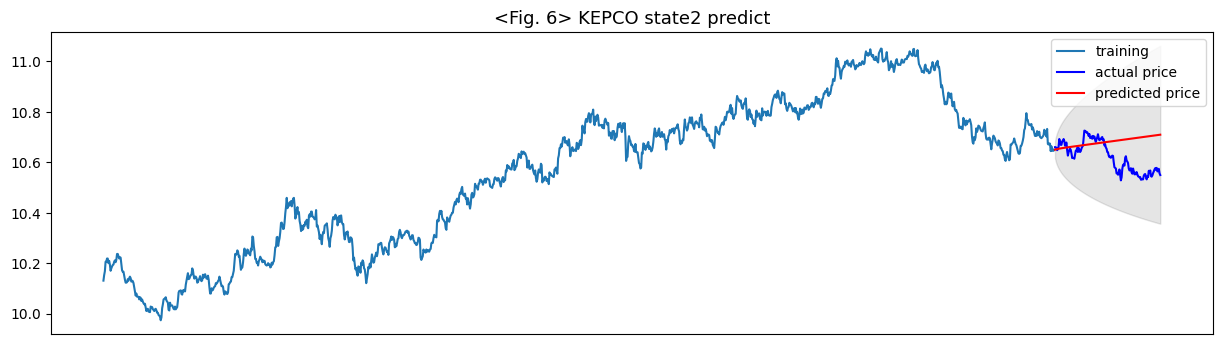

In [38]:
show_predict(kepco_train_data, kepco_test_data, "<Fig. 6> KEPCO state2 predict")

<br>

#### 모델 손실값
***
+ ARIMA 모델의 예측에 대한 손실값을 출력한 결과 `MAPE`가 7.90%임을 확인 할 수 있습니다.
***

In [39]:
show_loss(kepco_test_data)

**************************************************
MSE:  15182874.268370813
MAE:  3106.9477628399663
RMSE:  3896.5207901884487
MAPE: 7.90%
**************************************************


<br>

### 5.2. KT(030200)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; KT 데이터에 대한 ARIMA 모델 학습 및 평가를 시행 합니다. q가 0일 때와 1일 때로 구분하여 평가를 진행하였습니다. 그 결과, state1(p=1, q=0, d=1)일 때, MAPE 4.47% 이었으며 state2(p=1, q=1, d=1)일 때, MAPE 4.48% 임을 확인하였습니다. 따라서, q를 0으로 설정하였을 때, 보다 예측을 잘 한 것으로 이해할 수 있습니다. [표 7]은 KT 데이터에 대한 ARIMA 모델의 state에 따른 MAPE 손실값을 제시한 것입니다.
</span><br><br>

|State|p|q|d|MAPE|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|**state1**|1|0|1|**4.47**|
|**state2**|1|1|1|**4.48**|

[표 7] KT(030200) ARIMA 모델 MAPE 손실값

***

### 5.2.1. state1에 대한 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모수 p=1, q=0, d=1일 때, KT 데이터에 대한 모델의 학습 및 평가 입니다. MAE는 1406.383이며, MAPE는 4.47% 임을 확인하였습니다. &lt;Fig. 7>은 이를 시각화 한 것입니다. 실제 하락한 것을 모델이 잘 예측 하였습니다.
</span>

***

#### 모델 학습
***
+ `KT(030200)`에 대한 모수로 `p`=1, `q`=0, `d`=1을 설정한 `ARIMA` 모델을 학습 합니다.
***

In [40]:
model = ARIMA(kt_train_data, order=(1, 1, 0))   #p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1328
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3952.618
Method:                       css-mle   S.D. of innovations              0.012
Date:                Sun, 14 Nov 2021   AIC                          -7899.237
Time:                        15:05:25   BIC                          -7883.662
Sample:                             1   HQIC                         -7893.399
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -8.84e-05      0.000     -0.237      0.813      -0.001       0.001
ar.L1.D.close     0.0943      0.027      3.454      0.001       0.041       0.148
                                    Root

<br>

#### 모델 예측 시각화
***
+ `KT(030200)`에 대한 모수로 `p`=1, `q`=0, `d`=1을 설정한 `ARIMA` 모델을 예측을 시각화 합니다.
***

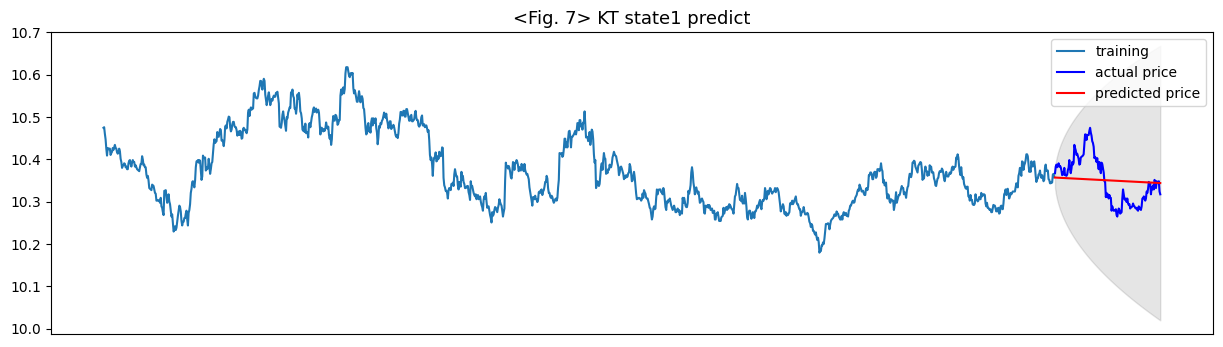

In [41]:
show_predict(kt_train_data, kt_test_data, "<Fig. 7> KT state1 predict")

<br>

#### 모델 손실값
***
+ ARIMA 모델의 예측에 대한 손실값을 출력한 결과 `MAPE`가 4.47%임을 확인 할 수 있습니다.
***

In [42]:
show_loss(kt_test_data)

**************************************************
MSE:  2783306.8811155683
MAE:  1406.383161547513
RMSE:  1668.3245730719093
MAPE: 4.47%
**************************************************


<br>

### 5.2.2. state2에 대한 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모수 p=1, q=1, d=1일 때, KT 데이터에 대한 모델의 학습 및 평가 입니다. MAE는 1406.852이며, MAPE는 4.48% 임을 확인하였습니다. &lt;Fig. 8>는 이를 시각화 한 것입니다. 앞의 state1과 비슷한 예측을 하였으며, state1보다 MAPE값이 0.01 상승하였습니다. 따라서 state1이 state2에 비해 더 잘 예측하였다고 할 수 있습니다.
</span>

***

#### 모델 학습
***
+ `KT(030200)`에 대한 모수로 `p`=1, `q`=1, `d`=1을 설정한 `ARIMA` 모델을 학습 합니다.
***

In [43]:
model = ARIMA(kt_train_data, order=(1, 1, 1))   #p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1328
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3958.217
Method:                       css-mle   S.D. of innovations              0.012
Date:                Sun, 14 Nov 2021   AIC                          -7908.435
Time:                        15:05:35   BIC                          -7887.669
Sample:                             1   HQIC                         -7900.652
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.756e-05      0.000     -0.243      0.808      -0.001       0.001
ar.L1.D.close    -0.5929      0.123     -4.828      0.000      -0.834      -0.352
ma.L1.D.close     0.6995      0.109     

<br>

#### 모델 예측 시각화
***
+ `KT(030200)`에 대한 모수로 `p`=1, `q`=1, `d`=1을 설정한 `ARIMA` 모델을 예측을 시각화 합니다.
***

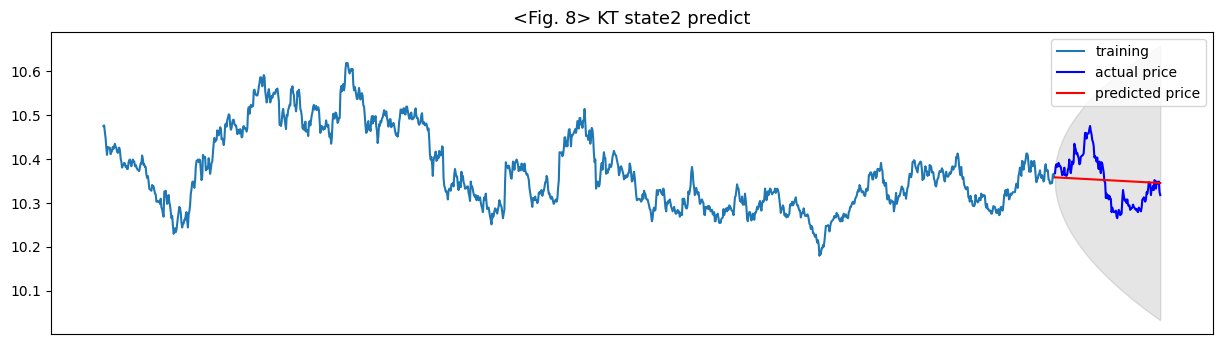

In [44]:
show_predict(kt_train_data, kt_test_data, "<Fig. 8> KT state2 predict")

<br>

#### 모델 손실값
***
+ ARIMA 모델의 예측에 대한 손실값을 출력한 결과 `MAPE`가 4.48%임을 확인 할 수 있습니다.
***

In [45]:
show_loss(kt_test_data)

**************************************************
MSE:  2783820.5815008446
MAE:  1406.852180027732
RMSE:  1668.4785229366437
MAPE: 4.48%
**************************************************


<br>

### 5.3. 현대(005380)
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 현대 데이터에 대한 ARIMA 모델 학습 및 평가를 시행 합니다. q가 0일 때와 1일 때로 구분하여 평가를 진행하였습니다.
그 결과, state1(p=1, q=0, d=1)일 때, MAPE 10.34% 이었으며 state2(p=1, q=1, d=1)일 때, MAPE 10.34% 임을 확인하였습니다. 따라서, q가 0일 때와 1일 때의 결과가 동일함을 알 수 있습니다. [표 8]은 현대 데이터에 대한 ARIMA 모델의 state에 따른 MAPE 손실값을 제시한 것입니다.
</span><br><br>

|State|p|q|d|MAPE|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|**state1**|1|0|1|**10.34**|
|**state2**|1|1|1|**10.34**|

[표 8] 현대(005380) ARIMA 모델 MAPE 손실값

***

### 5.3.1. state1에 대한 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모수 p=1, q=0, d=1일 때, 현대 데이터에 대한 모델의 학습 및 평가 입니다. MAE는 15282.185이며, MAPE는 10.34% 임을 확인하였습니다. &lt;Fig. 9>은 이를 시각화 한 것입니다. 실제 하락한 것을 모델이 잘 예측 하였습니다.
</span>

***

#### 모델 학습
***
+ `현대(005380)`에 대한 모수로 `p`=1, `q`=0, `d`=1을 설정한 `ARIMA` 모델을 학습 합니다.
***

In [46]:
model = ARIMA(hyundai_train_data, order=(1, 1, 0))   #p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1328
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3428.808
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 14 Nov 2021   AIC                          -6851.616
Time:                        15:05:46   BIC                          -6836.041
Sample:                             1   HQIC                         -6845.778
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.001     -0.316      0.752      -0.001       0.001
ar.L1.D.close     0.0479      0.027      1.745      0.081      -0.006       0.102
                                    Root

<br>

#### 모델 예측 시각화
***
+ `현대(005380)`에 대한 모수로 `p`=1, `q`=0, `d`=1을 설정한 `ARIMA` 모델을 예측을 시각화 합니다.
***

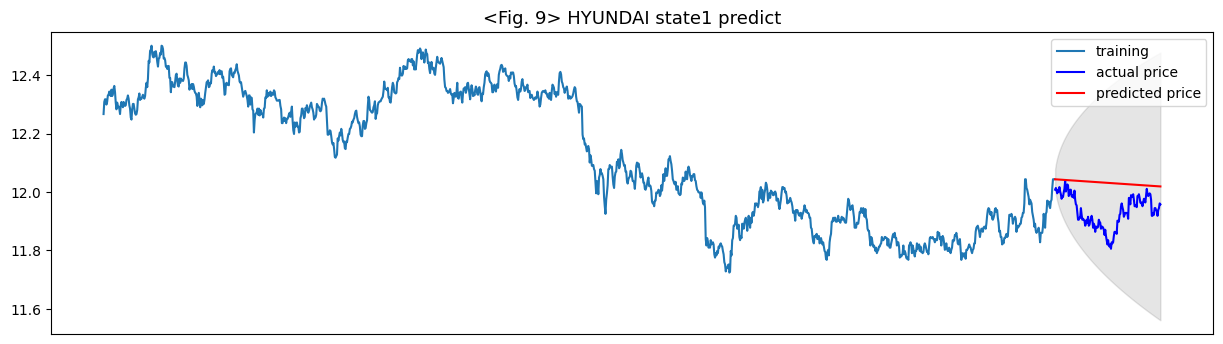

In [47]:
show_predict(hyundai_train_data, hyundai_test_data, "<Fig. 9> HYUNDAI state1 predict")

<br>

#### 모델 손실값
***
+ ARIMA 모델의 예측에 대한 손실값을 출력한 결과 `MAPE`가 10.34%임을 확인 할 수 있습니다.
***

In [48]:
show_loss(hyundai_test_data)

**************************************************
MSE:  301417264.1587773
MAE:  15282.184969274822
RMSE:  17361.37276135667
MAPE: 10.34%
**************************************************


<br>

### 5.3.2. state2에 대한 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ARIMA 모수 p=1, q=1, d=1일 때, 현대 데이터에 대한 모델의 학습 및 평가 입니다. MAE는 15286.900이며, MAPE는 10.34% 임을 확인하였습니다. &lt;Fig. 10>는 이를 시각화 한 것입니다. 앞의 state1과 비슷한 예측을 하였으며, state1와 MAPE값이 동일 합니다.
</span>

***

#### 모델 학습
***
+ `현대(005380)`에 대한 모수로 `p`=1, `q`=1, `d`=1을 설정한 `ARIMA` 모델을 학습 합니다.
***

In [49]:
model = ARIMA(hyundai_train_data, order=(1, 1, 1))   #p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1328
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3428.957
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 14 Nov 2021   AIC                          -6849.913
Time:                        15:05:57   BIC                          -6829.147
Sample:                             1   HQIC                         -6842.130
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.001     -0.319      0.749      -0.001       0.001
ar.L1.D.close    -0.2282      0.524     -0.436      0.663      -1.255       0.799
ma.L1.D.close     0.2771      0.517     

<br>

#### 모델 예측 시각화
***
+ `현대(005380)`에 대한 모수로 `p`=1, `q`=1, `d`=1을 설정한 `ARIMA` 모델을 예측을 시각화 합니다.
***

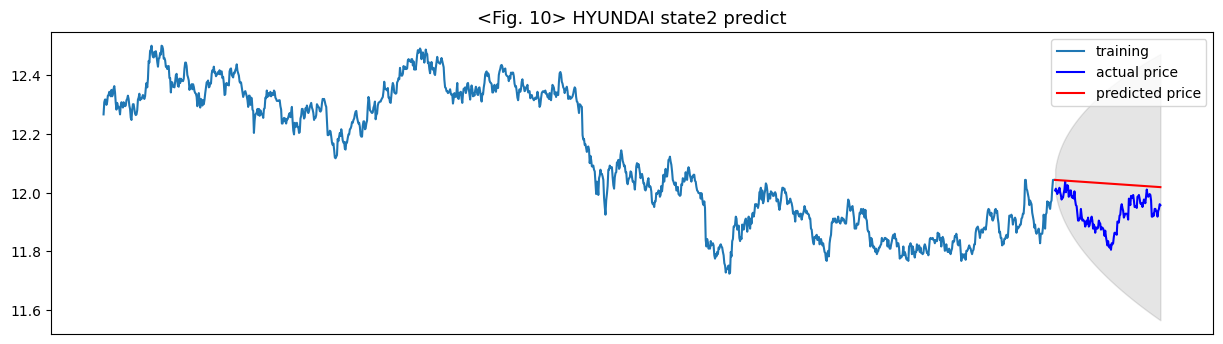

In [50]:
show_predict(hyundai_train_data, hyundai_test_data, "<Fig. 10> HYUNDAI state2 predict")

<br>

#### 모델 손실값
***
+ ARIMA 모델의 예측에 대한 손실값을 출력한 결과 `MAPE`가 10.34%임을 확인 할 수 있습니다.
***

In [51]:
show_loss(hyundai_test_data)

**************************************************
MSE:  301562675.23465747
MAE:  15286.900545309763
RMSE:  17365.560032278183
MAPE: 10.34%
**************************************************


<br>

## 6. 결론
***
<span style="font-size:11pt; line-height:1.8;">
   &nbsp; &nbsp; 본 예제에서는 ARIMA 모델을 사용하여 시계열 데이터를 예측합니다. 시계열 데이터로 '한국전력공사', 'KT', '현대'의 2012년부터 2017년까지의 약 5년 간의 주가(종가)를 사용하였습니다. 각 데이터에 대한 ARIMA 모델의 적절한 모수를 탐색하였으며, 모든 데이터는 state1(p=1, q=0, d=1), state2(p=1, q=1, d=1)의 경우로 나누어 모델을 학습, 평가 하였습니다. 평가 지표로는 MAPE를 사용하였습니다. 그 결과 한국전력공사의 경우 p=1, q=0, d=1일 때, MAPE가 7.78%이었으며, KT의 경우 p=1, q=0, d=1일 때, MAPE가 4.47%이고 현대의 경우 q가 0 또는 1인 모든 경우에서 MAPE가 10.34%임을 확인하였습니다. [표 9]는 각 종목에 대한 ARIMA 모델의 state별 MAPE를 제시한 것입니다.
</span><br><br>


|State|KEPCO(015760)|KT(030200)|HYUNDAI(005380)|
|:--------:|:--------:|:--------:|:--------:|
|**state1(p=1, q=0, d=1)**|7.78|4.47|10.34|
|**state2(p=1, q=1, d=1)**|7.90|4.48|10.34|

[표 9] 각 종목에 대한 ARIMA 모델의 state별 MAPE

***

#### 형상관리 기록
***
+ v1_1: 초기모델


+ v1_2: 실습 예제 진행
***